### Blood pseudotime

In [1]:
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(ggrastr))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(batchelor))
suppressPackageStartupMessages(library(destiny))


#####################
## Define settings ##
#####################
here::i_am("processing/1_create_seurat_rna.R")
source(here::here("settings.R"))
source(here::here("utils.R"))
source(here::here("mapping/run/mnn/mapping_functions.R"))

args = list()
args$sce <- io$rna.sce
#args$stage <- c('E9.5')#, 'E8.5', 'E9.5')
args$metadata <- paste0(io$basedir,"/results/rna/mapping/sample_metadata_after_mapping.txt.gz")
args$atlas_metadata <- "/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/extended/sample_metadata.txt.gz"
args$cdr_threshold = 0.1
args$logFC_thr = 1
args$outdir <- paste0(io$basedir,"/results/rna/blood")
args$metascape = file.path(args$outdir, 'metascape')
# If passing multiple timepoints split in vector
#args$stage = strsplit(args$stage, "_")[[1]] 

dir.create(args$metascape, recursive=TRUE, showWarnings = FALSE)

### Functions
# minmax normalisation 
minmax = function(x){(x-min(x))/(max(x)-min(x))}
# Reversing vector order (for pseudotime)
reverse = function(x){-x + max(x) + min(x)}

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/code



In [2]:
set.seed(1234)

In [3]:
ct_blood = c('Haematoendothelial progenitors',
             'Blood progenitors',
             'Erythroid')


##########################
## Load sample metadata ##
##########################

sample_metadata <- fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE & celltype.mapped_mnn %in% ct_blood] %>%
    .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)]


# if(test){
#     sample_metadata = sample_metadata[sample(1:nrow(sample_metadata), nrow(sample_metadata)/4)]
# }

###############
## Load data ##
###############

# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

In [4]:
sce

class: SingleCellExperiment 
dim: 29453 2709 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(2709): SLX-21143_SITTA2_HTJH3DSX2#AAACCCAAGATGTTCC-1
  SLX-21143_SITTA2_HTJH3DSX2#AAACGAACACACCAGC-1 ...
  SLX-21143_SITTH3_HTJH3DSX2#TTTATGCTCCTAAGTG-1
  SLX-21143_SITTH3_HTJH3DSX2#TTTGGTTGTTAGCTAC-1
colData names(19): sample barcode ... closest.cell_mnn pool
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [5]:
# Filter genes
# Get gene metadata
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol")] %>%
  .[symbol!="" & ens_id%in%rownames(sce)] %>%
  .[!duplicated(symbol)]

# Imprinted genes
imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
                       grep('paternally', gene_metadata$description)), symbol]


genes_keep = rownames(sce) %>%
    .[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",.,invert=T)] %>% # filter out non-informative genes
    .[grep("^Hbb|^Hba",.,invert=T)] %>% # Removing Haem genes due to spilling over from erythroids to other cells 
    .[!. %in% c(imprint, 'Grb10', 'Nnat')] %>%  # remove imprinted genes
    .[!. %in% c("Xist", "Tsix")] %>%  # remove Xist & Tsix
    .[!.=="tomato-td"] %>% # remove tomato itself
    .[!.%in%gene_metadata[chr=="chrY",symbol]]

sce = sce[genes_keep,]

In [7]:
# Keep only genes with minimum proportion of cells expressing
CDR = data.table(gene = rownames(sce),
                 cdr_WT = rowMeans(counts(sce[,colData(sce)$tdTom_corr==FALSE])>0),
                 cdr_KO = rowMeans(counts(sce[,colData(sce)$tdTom_corr==TRUE])>0)) %>%
    .[order(-cdr_WT)] %>%
    .[,pass_CDR := ifelse(cdr_WT > args$cdr_threshold | cdr_KO > args$cdr_threshold, TRUE, FALSE)]

In [8]:
length(CDR[pass_CDR==TRUE, gene])

[1] 8564

In [9]:
#######################
## Feature selection ##
#######################
args$features = 1000

decomp <- modelGeneVar(sce)
decomp <- decomp[decomp$mean > 0.01,]
hvgs <- decomp[order(decomp$FDR),] %>% 
    as.data.table(., keep.rownames=T) %>% 
     head(n=args$features) %>% .$rn

# Subset HVGs
sce_filt <- sce[hvgs,]
dim(sce_filt)

sce_filt <- runPCA(sce_filt, ncomponents = 5, ntop=nrow(sce_filt))

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


[1] 1000 2709

In [10]:
reducedDim(sce, "PCA") = reducedDim(sce_filt, "PCA")
pca = as.data.frame(reducedDim(sce_filt, "PCA"))

In [11]:
dm <- DiffusionMap(pca, n_pcs=5)
# Add to the SingleCellExperiment object
reducedDim(sce, "DiffusionMap") <- dm@eigenvectors[,c(1,2)]

Warning message:
“as(<dsCMatrix>, "dsTMatrix") is deprecated since Matrix 1.5-0; do as(., "TsparseMatrix") instead”


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


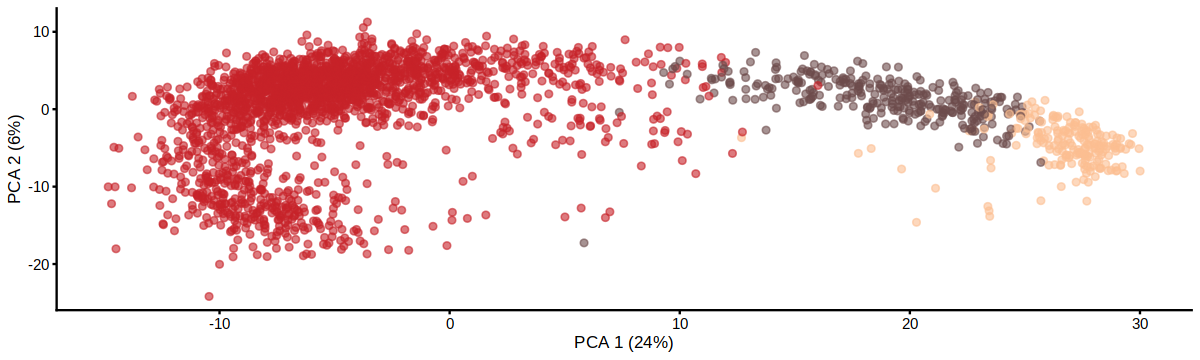

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


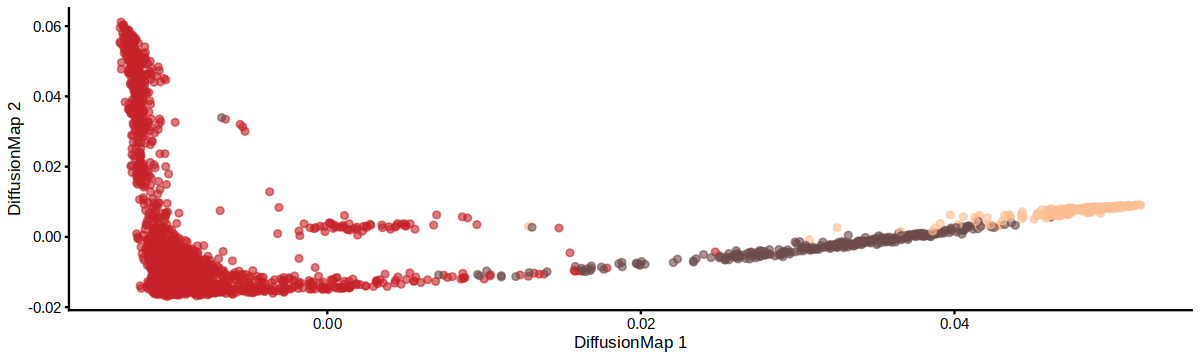

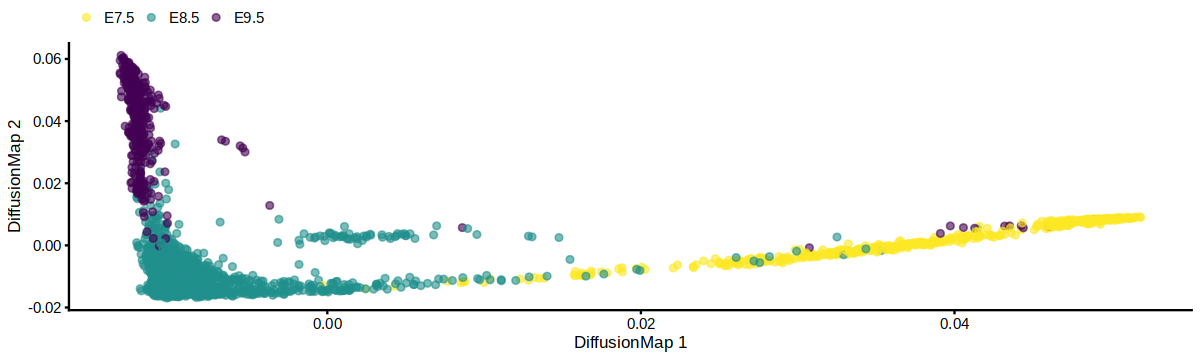

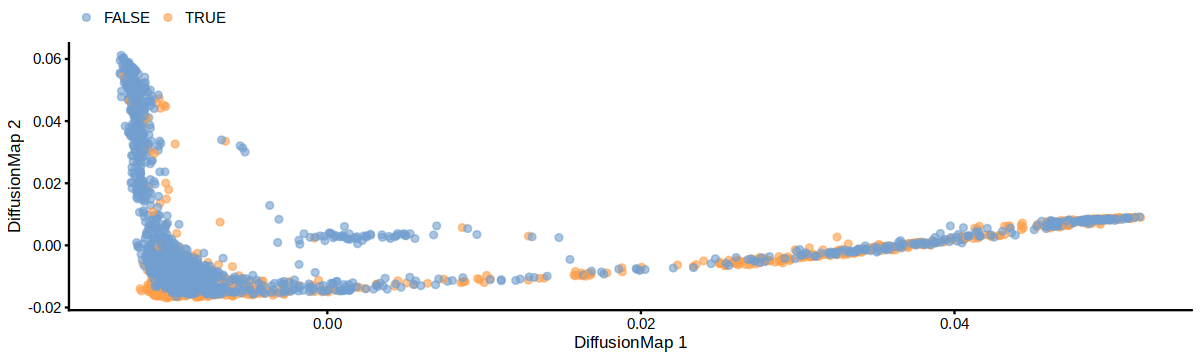

In [12]:
# Plot
options(repr.plot.width=10, repr.plot.height=3)
plotReducedDim(sce, dimred = "PCA", colour_by="celltype.mapped_mnn", ncomponents = c(1,2)) +
  scale_colour_manual(values=opts$celltype.colors) + theme(legend.position="none")

plotReducedDim(sce, dimred = "DiffusionMap", colour_by="celltype.mapped_mnn", ncomponents = c(1,2)) +
  scale_colour_manual(values=opts$celltype.colors) + theme(legend.position="none")

plotReducedDim(sce, dimred = "DiffusionMap", colour_by="stage", ncomponents = c(1,2)) +
  scale_colour_manual(values=opts$stage.colors) + theme(legend.position="top", legend.title = element_blank())

plotReducedDim(sce, dimred = "DiffusionMap", colour_by="tdTom_corr", ncomponents = c(1,2)) +
  theme(legend.position="top", legend.title = element_blank())

# Pseudotime inference
https://www.bioconductor.org/packages/release/bioc/vignettes/tradeSeq/inst/doc/tradeSeq.html
https://www.bioconductor.org/packages/release/bioc/manuals/tradeSeq/man/tradeSeq.pdf

In [10]:
suppressPackageStartupMessages(library(tradeSeq))
suppressPackageStartupMessages(library(slingshot))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(BiocParallel))
suppressPackageStartupMessages(library(circlize))

In [14]:
# reducedDim(sce_filt, "PCA") = pca.corrected

In [15]:
reducedDim(sce, "PCA") = pca

In [16]:
sce <- slingshot(sce, reducedDim='PCA')
head(sce$slingPseudotime_1)

No cluster labels provided. Continuing with one cluster.



[1] 25.32404 29.41781 25.76654 32.08417 26.02279 32.98468

In [17]:
args$outdir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/results/rna/blood"

In [18]:
saveRDS(sce, file.path(args$outdir, 'sce_slingshot.rds'))

In [19]:
embedded <- embedCurves(sce, "DiffusionMap")
embedded <- slingCurves(embedded)[[1]] # only 1 path.
embedded <- data.frame(embedded$s[embedded$ord,])

In [20]:
meta = as.data.table(colData(sce)[,-grep('slingshot', colnames(colData(sce)))], keep.rownames=T) %>% setnames('rn', 'cell') %>% 
    .[, pseudotime := reverse(slingPseudotime_1)] #%>%
  #  .[, pseudotime := minmax(pseudotime)]

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


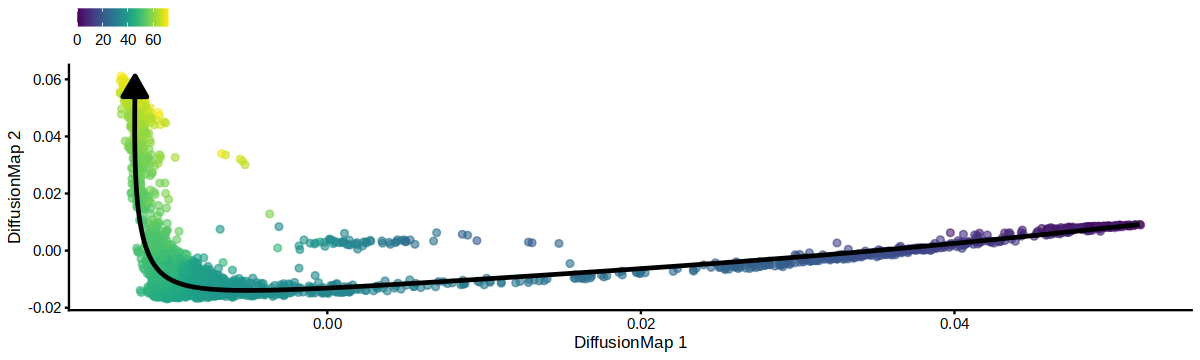

In [21]:
colData(sce) <- meta %>% tibble::column_to_rownames("cell") %>% DataFrame

plotReducedDim(sce, dimred = "DiffusionMap", colour_by="pseudotime", ncomponents = c(1,2)) +
    geom_path(data=embedded, 
              aes(x=DC1, y=DC2), 
              size=1, 
              arrow=grid::arrow(ends = 'first', type = 'closed', length = unit(0.20, "inches"))) + 
    theme(legend.position="top", legend.title = element_blank())

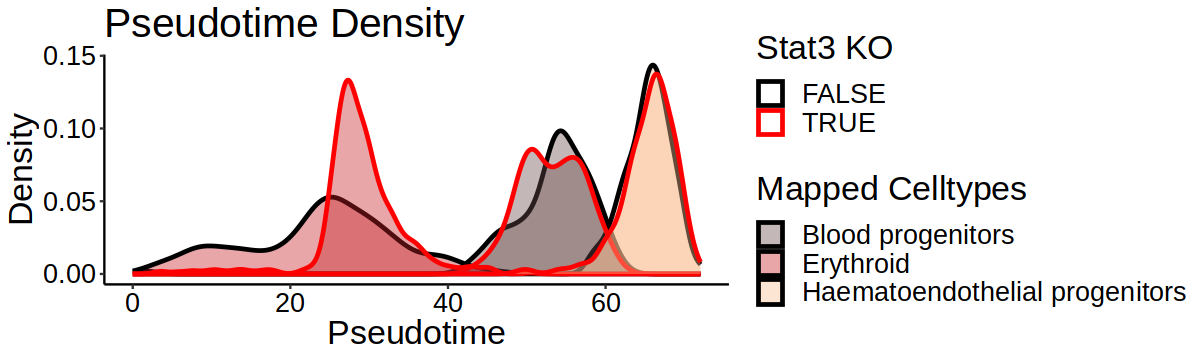

In [22]:
ggplot(meta, aes(slingPseudotime_1, col=tdTom_corr, fill=celltype.mapped_mnn)) + 
    geom_density(alpha=0.4, size=1) + 
    scale_colour_manual(values=c('TRUE'='red', 'FALSE'='black'), name='Stat3 KO') + 
    scale_fill_manual(values = opts$celltype.colors, name='Mapped Celltypes') +
    ggtitle('Pseudotime Density') + 
    xlab('Pseudotime') + ylab('Density') + 
    theme_classic() + 
    theme(text = element_text(size=20),
          axis.text = element_text(color='black'))

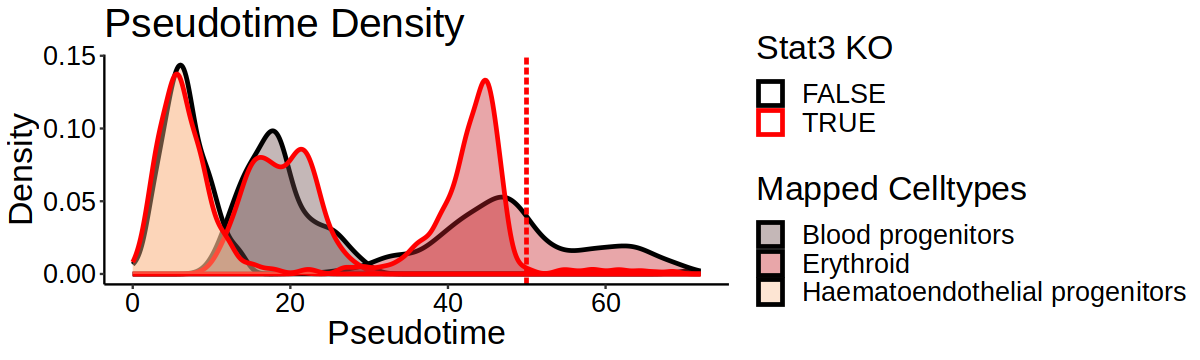

In [23]:
ggplot(meta, aes(pseudotime, col=tdTom_corr, fill=celltype.mapped_mnn)) + 
    geom_density(alpha=0.4, size=1) + 
    scale_colour_manual(values=c('TRUE'='red', 'FALSE'='black'), name='Stat3 KO') + 
    scale_fill_manual(values = opts$celltype.colors, name='Mapped Celltypes') + 
    geom_vline(xintercept=50, linetype='longdash', color='red', size=1) + 
    ggtitle('Pseudotime Density') + 
    xlab('Pseudotime') + ylab('Density') + 
    theme_classic() + 
    theme(text = element_text(size=20),
          axis.text = element_text(color='black'))

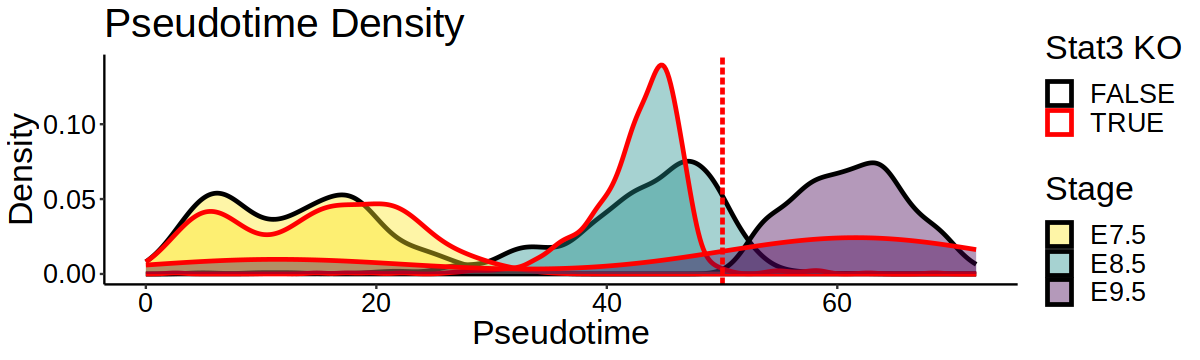

In [24]:
# E9.5 KO look like they quite spread out but it's because there are basically none
ggplot(meta, aes(pseudotime, col=tdTom_corr, fill=stage)) + 
    geom_density(alpha=0.4, size=1) + 
    scale_colour_manual(values=c('TRUE'='red', 'FALSE'='black'), name='Stat3 KO') + 
    scale_fill_manual(values = opts$stage.colors, name='Stage') +
    geom_vline(xintercept=50, linetype='longdash', color='red', size=1) + 
    ggtitle('Pseudotime Density') + 
    xlab('Pseudotime') + ylab('Density') + 
    theme_classic() + 
    theme(text = element_text(size=20),
          axis.text = element_text(color='black'))

In [25]:
# Flip pseudotime & remove pseudotime without Stat3 KO overlap
meta = meta[pseudotime < 50] 

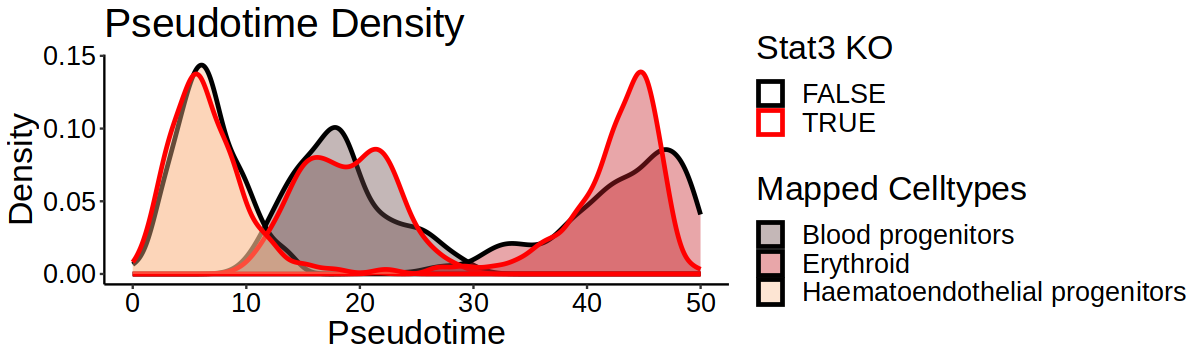

In [26]:
ggplot(meta, aes(pseudotime, col=tdTom_corr, fill=celltype.mapped_mnn)) + 
    geom_density(alpha=0.4, size=1) + 
    scale_colour_manual(values=c('TRUE'='red', 'FALSE'='black'), name='Stat3 KO') + 
    scale_fill_manual(values = opts$celltype.colors, name='Mapped Celltypes') + 
    ggtitle('Pseudotime Density') + 
    xlab('Pseudotime') + ylab('Density') + 
    theme_classic() + 
    theme(text = element_text(size=20),
          axis.text = element_text(color='black'))

In [27]:
# subset sce_filt 
sce_filt = sce[, meta$cell]

In [31]:
# Keep only genes that pas CDR
sce_filt = sce_filt[CDR[pass_CDR==TRUE, gene], ]

In [32]:
# Only keep WT cells that do not express tdTom
meta_filt = meta[tdTom==tdTom_corr]
sce_filt = sce_filt[,meta_filt$cell]

In [33]:
saveRDS(sce_filt, file.path(args$outdir, 'sce_slingshot_filt.rds'))

# Trade-seq

In [34]:
dim(counts(sce_filt))

[1] 8564 2179

In [38]:
# Set parallel cores
BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 16
set.seed(6)

In [39]:
options(repr.plot.width = 10, repr.plot.height=3)
icMat <- evaluateK(counts = as.matrix(assays(sce_filt)$counts),
                   pseudotime = sce_filt$pseudotime,
                   cellWeights = rep(1,ncol(sce_filt)),
                   conditions = factor(colData(sce)$tdTom_corr),
                   nGenes = 300,
                   parallel = TRUE,
                   BPPARAM=BPPARAM,
                   k = 3:15,
                   verbose = FALSE)

Fitting lineages with multiple conditions. This method has been tested on a couple of datasets, but is still in an experimental phase.



  |                                                                      |   0%

In [35]:
# # Set all cells to belong to one trajectory
# cellWeights <- rep(1,ncol(sce_filt))

# # create a model matrix -> Comparing within Embryo pools
# U <- model.matrix(~sce_filt$pool)

# sceGAM <- fitGAM(counts = counts(sce_filt),
#                  conditions = as.factor(sce_filt$tdTom_corr),
#                  U = U,
#                  pseudotime= sce_filt$pseudotime,
#                  cellWeights=cellWeights,
#                  nknots=6, # put at 6!
#                  parallel = TRUE,
#                  BPPARAM=BPPARAM,
#                  verbose=T)

# saveRDS(sceGAM, file.path(args$outdir,"sceGAM.rds"))

In [6]:
getwd()

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/code/blood"

In [7]:
sceGAM = readRDS(file.path(args$outdir,"sceGAM.rds"))

In [11]:
# Test if l2fc should be changed around? Higher than 0.75 rather than lower
condRes <- conditionTest(sceGAM, l2fc = args$logFC_thr)
condRes$padj <- p.adjust(condRes$pvalue, "fdr")

In [12]:
condRes = condRes %>% as.data.table(keep.rownames=T) %>%
    setnames('rn', 'gene') %>%
    .[,sig:=ifelse(padj<=0.05, TRUE, FALSE)] %>%
    .[order(padj, -waldStat)]

In [14]:
args$outdir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/results/rna/blood"

In [15]:
fwrite(condRes, file.path(args$outdir, 'conditionTest_results.txt.gz'))

In [16]:
plot_traj = function(gene, size=0.2, alpha=0.3){
    ggplot(as.data.frame(colData(sce_filt)[,-20]), aes(pseudotime, as.vector(logcounts(sce_filt[gene,])), col=tdTom_corr)) + 
        geom_point(size=size, alpha=alpha) + 
        geom_smooth() + 
        scale_colour_manual(values=c('TRUE'='red', 'FALSE'='black'), name='Stat3 KO') + 
        ylab('logcounts') + 
        xlab('Pseudotime') + 
        ggtitle(gene) + 
        theme_bw() + 
        theme(text=element_text(size=20))
}

In [17]:
trans <- div_gradient_pal(low='#5a77ff', mid='lightyellow', high='#d66468')
cols <- trans(seq(0,1, length.out=20))

In [18]:
col_fun = colorRamp2(seq(0, 50, 5), viridis::viridis(length(seq(0, 50, 5))))

In [19]:
ha = HeatmapAnnotation(pseudotime = 1:50,
                       col = list(pseudotime = col_fun))

In [20]:
length(condRes[sig==TRUE, gene])

[1] 47

In [21]:
conditionGenes = head(condRes[sig==TRUE, gene], 100)

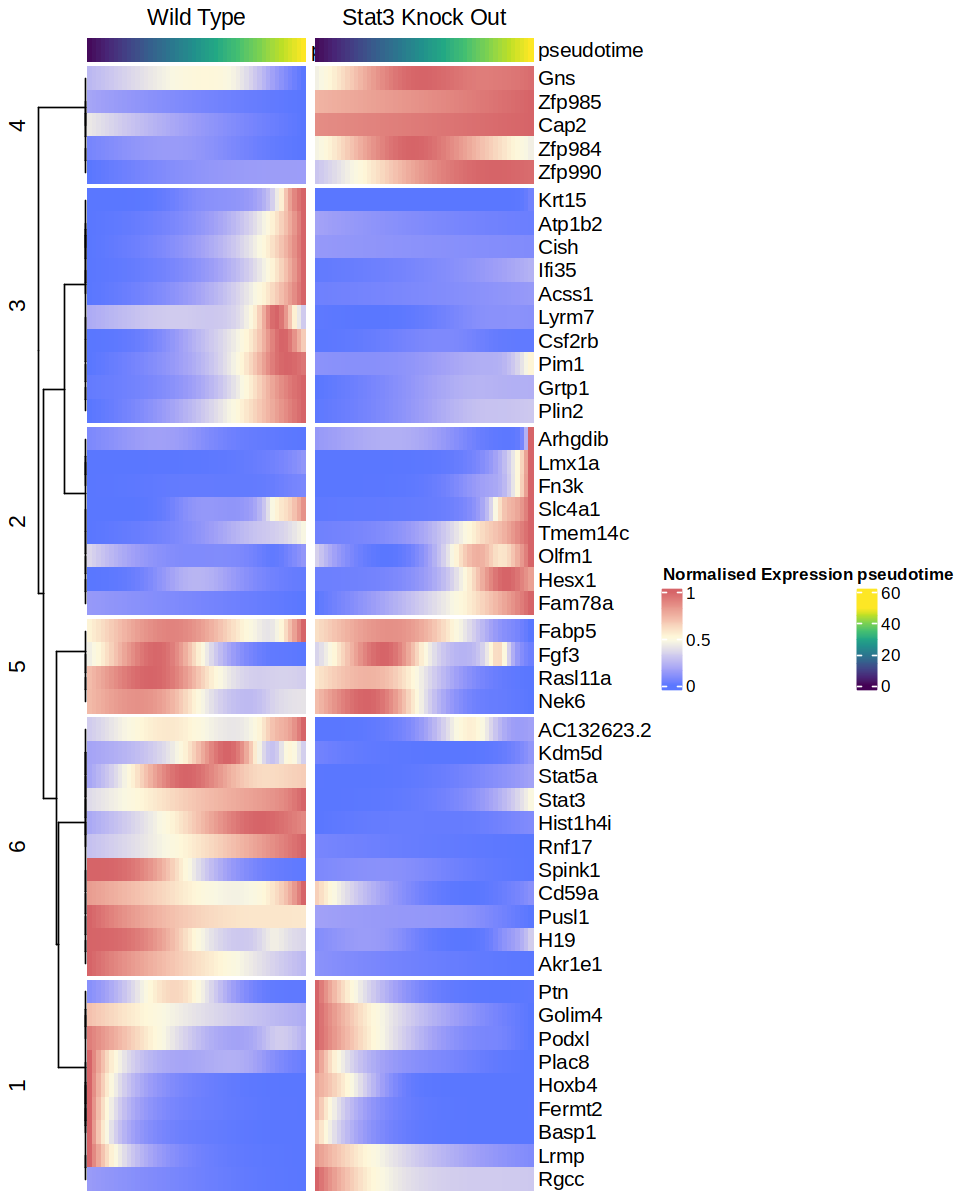

In [22]:
yhatSmooth <- predictSmooth(sceGAM, gene = conditionGenes, nPoints = 50, tidy = FALSE)
yhatSmooth_minmax = t(apply(yhatSmooth, 1, minmax)) 
WT = yhatSmooth_minmax[, grepl('FALSE', colnames(yhatSmooth_minmax))]
KO = yhatSmooth_minmax[, grepl('TRUE', colnames(yhatSmooth_minmax))]

# Clustering
k = 6
group = kmeans(yhatSmooth_minmax, centers = k)$cluster
row_clust = cluster_within_group(t(yhatSmooth_minmax), group)

hm_list = Heatmap(WT, 
                  cluster_rows = row_clust,
                  cluster_columns = FALSE,
                  column_title = 'Wild Type',
                  show_column_names  = FALSE,
                  row_split = k,
                  #row_split = as.data.frame(group), 
                  #km = 6,
                  col = cols,
                  heatmap_legend_param = list(title = 'Normalised Expression'), 
                  top_annotation = ha) + 
          Heatmap(KO, 
                  cluster_columns = FALSE, 
                  column_title = 'Stat3 Knock Out',
                  show_column_names  = FALSE,
                  col = cols,
                  show_heatmap_legend = F, 
                  top_annotation = ha)
options(repr.plot.height=10, repr.plot.width=8)
draw(hm_list)

In [24]:
# Now combine clusters together in a single plot
smooth.dt = as.data.table(yhatSmooth_minmax, keep.rownames=T) %>% 
    setnames('rn', 'gene') %>% 
    melt(., id.vars = 'gene', variable.names = 'column', value.names= 'value') %>%
    .[,tdTom := ifelse(grepl('FALSE', variable), 'WT', 'Stat3 KO')] %>%
    .[,tdTom := factor(tdTom, levels=c('WT', 'Stat3 KO'))] %>%
    .[,pseudotime := as.numeric(gsub('point', '', str_split(variable, '_') %>% map_chr(3)))] %>% 
    merge(., 
          as.data.table(group, keep.rownames=T) %>% setnames('rn', 'gene'),
          by='gene') 

mean.dt = smooth.dt %>% copy() %>% 
    .[,value := mean(value), by=c('group', 'tdTom', 'pseudotime')] %>% 
    unique(by=c('group', 'tdTom', 'pseudotime'))

nrow(smooth.dt)
nrow(mean.dt)

[1] 4700

[1] 600

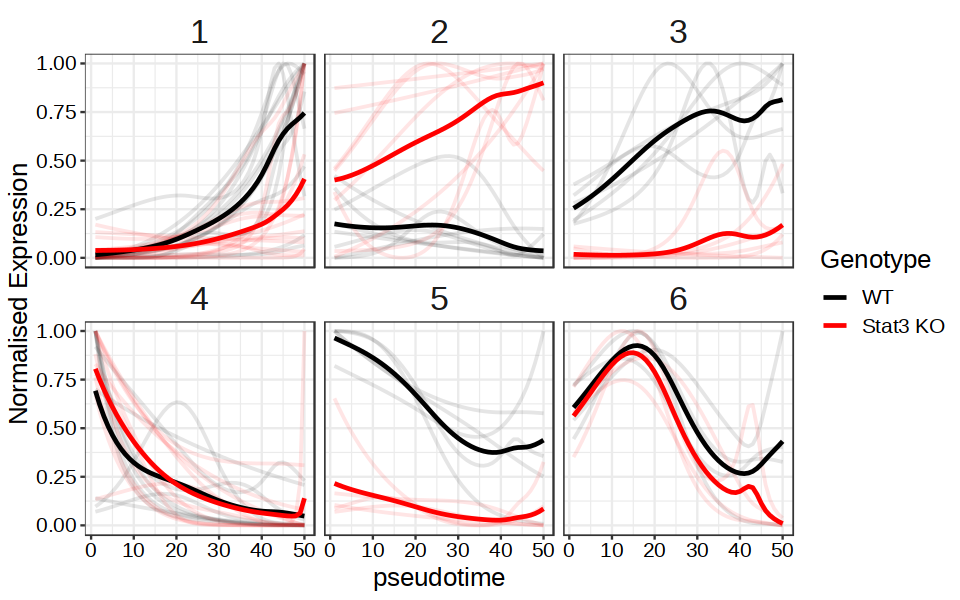

In [237]:
options(repr.plot.height=5, repr.plot.width=8)
ggplot(smooth.dt, aes(pseudotime, value, col=tdTom, group.by=gene)) + 
    geom_line(alpha=0.1, size=0.8) +
    geom_line(data=mean.dt, size=1) + 
    scale_color_manual(values=c('WT' = 'black', 'Stat3 KO' = 'red'), name='Genotype') + 
    facet_wrap(~group) + 
    ylab('Normalised Expression') + 
    theme_bw() + 
    theme(strip.background=element_blank(),
          strip.text = element_text(size=20), 
         text = element_text(size=15, color='black'),
         axis.text = element_text(color='black'))

In [359]:
genes = c('Stat3', 
          'Stat5a',
          'Cish', # canonical Stat3 target
          'Pim1', # canonical Stat3 target
          'Ifi35', # interferon induced
          'Plin2', # ?
          'Krt15', # ? Krt18 is a erythroid stem cell markers (?)
          'Cd59a' # plays a role in complement response, not described in erythroids
         )
options(repr.plot.width = 10, repr.plot.height=5)
plots = mclapply(genes, function(x){
        p = plot_traj(x, size=0.01, alpha=0.1) + 
                scale_x_continuous(breaks = seq(0, 50, by = 25)) + 
                theme(axis.title=element_blank(),
                      axis.text.x=element_text(color='black'),
                      axis.text.y=element_text(color='black'))
    }, mc.cores=24) 
p = ggarrange(plotlist=plots, nrow=2, ncol=4, common.legend=TRUE, legend="right")

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


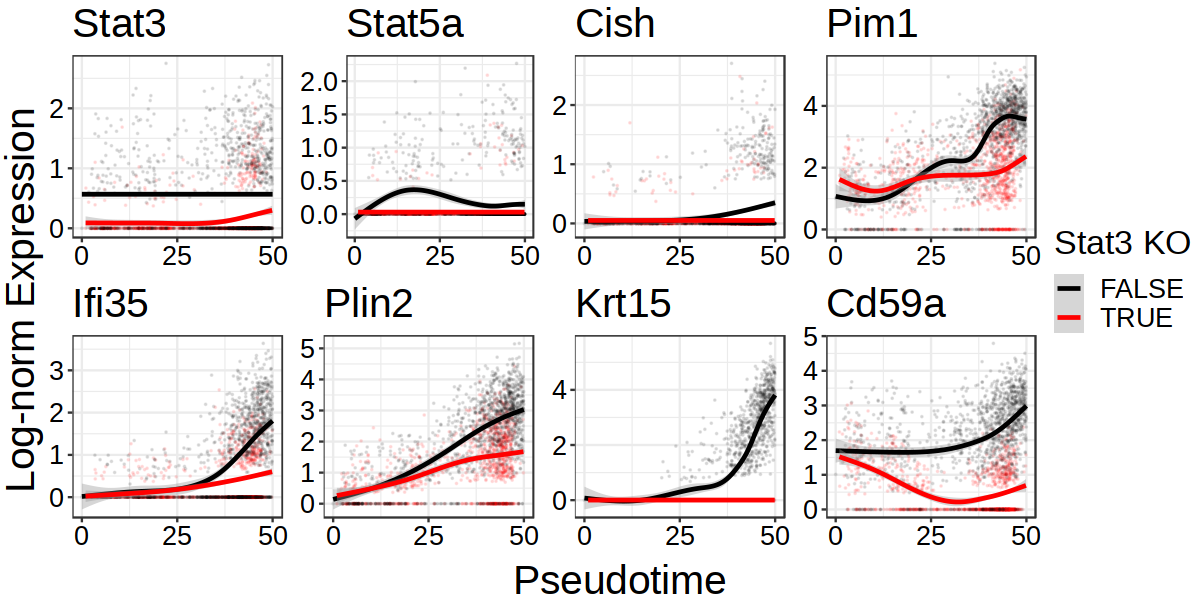

In [360]:
annotate_figure(p, left = textGrob("Log-norm Expression", rot = 90, vjust = 0.5, hjust=0.5, gp = gpar(cex = 2)),
                    bottom = textGrob("Pseudotime", gp = gpar(cex = 2)))

In [348]:
group[order(group)]

Zfp985     Zfp984       Cap2     Zfp990        Gns       Lrmp     Fermt2 
         1          1          1          1          1          2          2 
     Basp1      Hoxb4      Plac8       Rgcc     Golim4      Podxl        Ptn 
         2          2          2          2          2          2          2 
    Csf2rb      Ifi35       Pim1     Atp1b2       Cish      Lyrm7      Grtp1 
         3          3          3          3          3          3          3 
     Plin2      Acss1      Krt15      Lmx1a      Olfm1      Hesx1    Arhgdib 
         3          3          3          4          4          4          4 
      Fn3k     Fam78a    Tmem14c     Slc4a1       Fgf3      Fabp5    Rasl11a 
         4          4          4          4          5          5          5 
      Nek6      Cd59a        H19     Akr1e1      Pusl1   Hist1h4i      Stat3 
         5          6          6          6          6          6          6 
    Stat5a      Kdm5d AC132623.2      Rnf17     Spink1 
         6          6          6          6          6

In [349]:
length(group)

[1] 47

In [350]:
genes = names(group)
options(repr.plot.width = 15, repr.plot.height=25)
plots = mclapply(genes, function(x){
        p = plot_traj(x, size=0.01, alpha=0.1) + 
                scale_x_continuous(breaks = seq(0, 50, by = 25)) + 
                theme(axis.title=element_blank(),
                      axis.text.x=element_text(color='black'),
                      axis.text.y=element_text(color='black'))
    }, mc.cores=24) 
p = ggarrange(plotlist=plots, nrow=10, ncol=5, common.legend=TRUE, legend="right")

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 

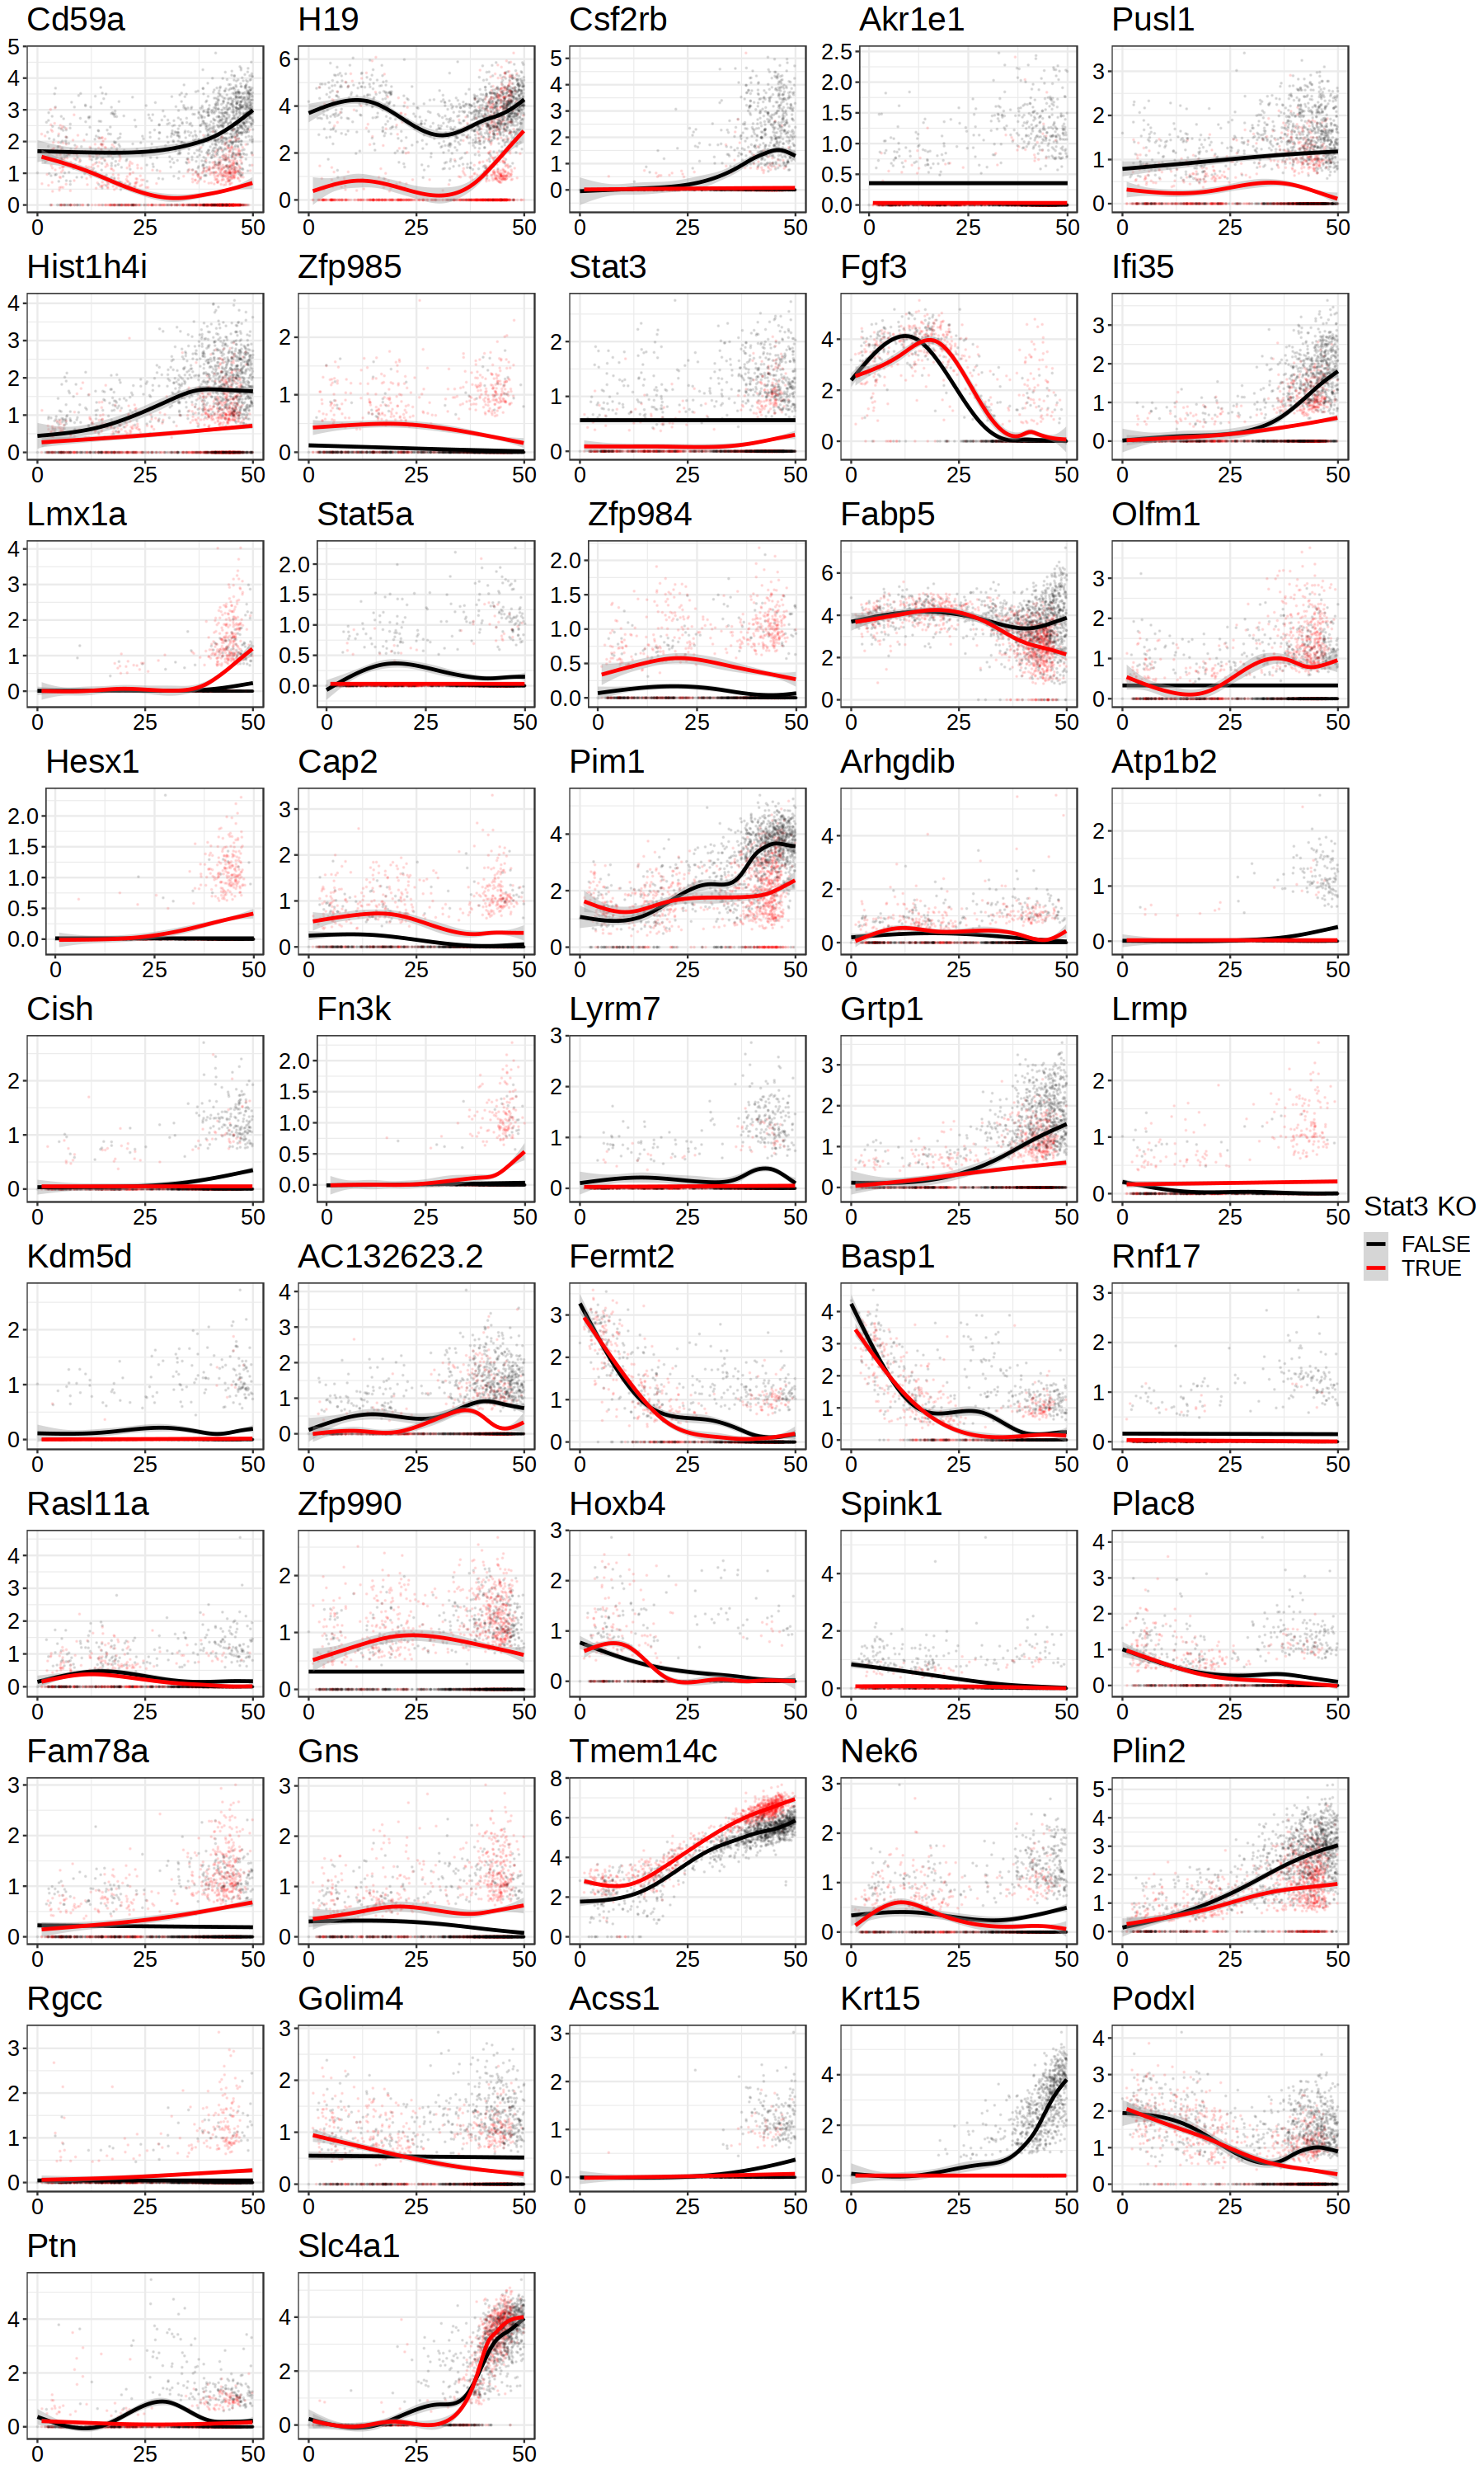

In [351]:
p

In [352]:
genes = c('Stat5b', 'Rragd', 'Cd24a')
options(repr.plot.width = 15, repr.plot.height=25)
plots = mclapply(genes, function(x){
        p = plot_traj(x, size=0.01, alpha=0.1) + 
                scale_x_continuous(breaks = seq(0, 50, by = 25)) + 
                theme(axis.title=element_blank(),
                      axis.text.x=element_text(color='black'),
                      axis.text.y=element_text(color='black'))
    }, mc.cores=24) 
p = ggarrange(plotlist=plots, nrow=10, ncol=5, common.legend=TRUE, legend="right")

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


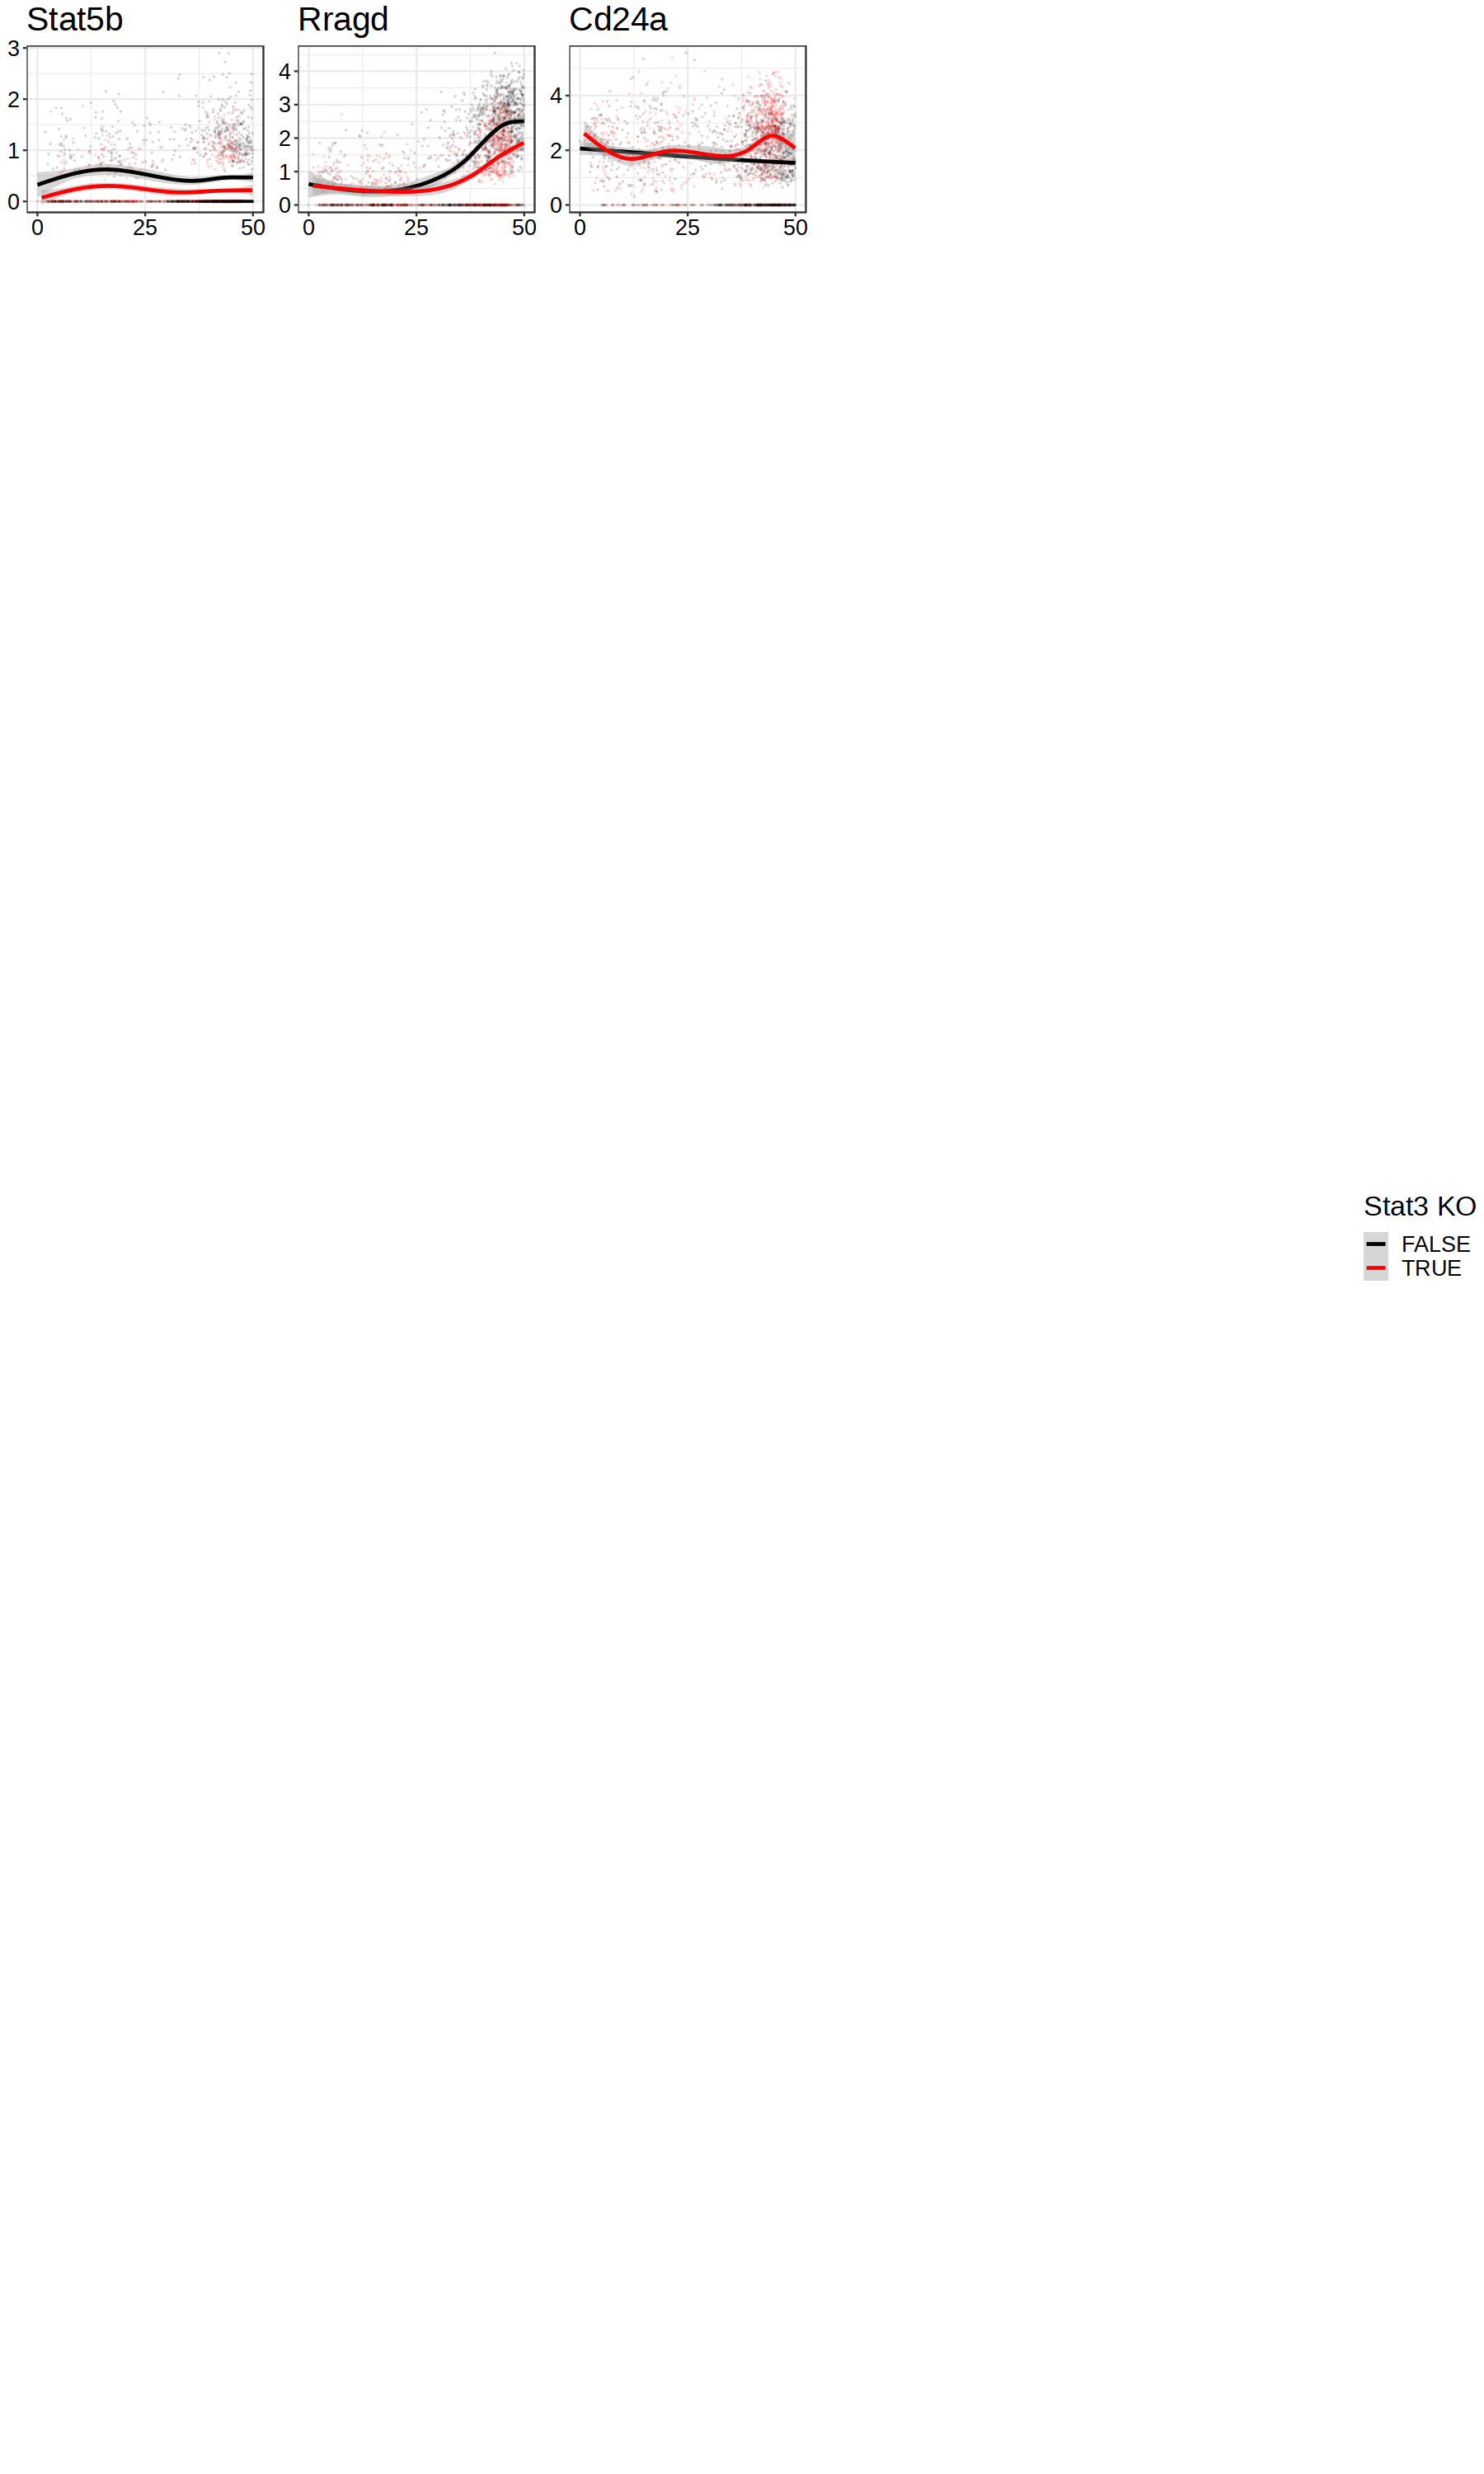

In [353]:
p

In [75]:
#### Same but from log counts 

# # Get log counts
# logcounts = as.data.table(as.matrix(logcounts(sce_filt[conditionGenes,])), keep.rownames=T) %>% setnames('rn', 'gene')
# # wide to long
# long = melt(logcounts, id.vars = c("gene"),
#                variable.name = "cell", value.name = "Expr")

# # Annotate pseudotime bin & condition
# meta = as.data.table(colData(sce_filt)[,-20], keep.rownames=T) %>%
#     setnames('rn', 'cell') %>% 
#     .[,c('cell', 'pseudotime','tdTom_corr')] %>% # ,'celltype.mapped_mnn', 'stage'
#     .[,pseudotime_bin:=cut(pseudotime, 50)] %>%
#     .[match(long$cell, cell),]

# long = cbind(long, meta[,-'cell'])

# # mean per pseudotime bin & condition
# long = long %>% 
#    # .[,Expr := (Expr-min(Expr))/(max(Expr)-min(Expr)), by='gene'] %>%  # minmax normalisation
#     .[,mean_expr := mean(Expr), by=c('gene','pseudotime_bin', 'tdTom_corr')] %>% 
#     #.[,mean_expr := scale(mean_expr), by='gene'] %>%  # scaling
#     .[,mean_expr := (mean_expr-min(mean_expr))/(max(mean_expr)-min(mean_expr)), by='gene'] %>%  # minmax normalisation
#     unique(by=c('gene', 'pseudotime_bin', 'tdTom_corr')) %>% 
#     .[order(pseudotime_bin),] %>%
#     .[,mean_expr_roll := frollmean(mean_expr, 3, align = 'right'), by=c('gene', 'tdTom_corr')] %>% .[,mean_expr_roll := ifelse(is.na(mean_expr_roll), mean_expr, mean_expr_roll)]


# # smooth using rolling average?

# # split by condition
# WT = long[tdTom_corr==FALSE,c('gene','pseudotime_bin', 'mean_expr')] %>%
#     dcast(., gene ~ pseudotime_bin, value.var='mean_expr') %>%
#    as.data.frame() %>% tibble::column_to_rownames('gene') %>% as.matrix

# KO = long[tdTom_corr==TRUE,c('gene','pseudotime_bin', 'mean_expr')]  %>% 
#     dcast(., gene ~ pseudotime_bin, value.var='mean_expr') %>%
#     as.data.frame() %>% tibble::column_to_rownames('gene') %>% as.matrix

# # head(logcounts)
# # head(long)
# # head(WT)

# summary(colnames(WT) == colnames(KO))

# options(repr.plot.height=4)

# ggplot(long[gene=='Cd59a',], aes(pseudotime_bin, mean_expr, col=tdTom_corr, group=tdTom_corr)) + 
#         geom_point(size=0.2, alpha=0.3) + 
#         geom_line() + 
#         scale_colour_manual(values=c('TRUE'='red', 'FALSE'='black'), name='Stat3 KO') + 
#         ylab('logcounts') + 
#         xlab('Pseudotime') + 
#         theme_bw() + 
#         theme(text=element_text(size=20))

# hm_list = Heatmap(WT, 
#                   cluster_columns = FALSE,
#                   column_title = 'Wild Type',
#                   show_column_names  = FALSE) + 
#           Heatmap(KO, 
#                   cluster_columns = FALSE, 
#                   column_title = 'Stat3 Knock Out')

# options(repr.plot.height=15)

# draw(hm_list)